### Load models


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import re
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn
from net.vit import vit

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [2]:
device = torch.device("cuda:1")
# Dataset params
dataset_num_classes = {"cifar10": 10, "cifar100": 100, "svhn": 10, "lsun": 10, "tiny_iamgenet": 200}
dataset_loader = {"cifar10": cifar10, "cifar100": cifar100, "svhn": svhn, "mnist": mnist, "lsun": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
    "vit":vit
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512,"vit":768}

batch_size = 256
dataset = "cifar10"
ood_dataset = "svhn"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run17/vgg16_sn_3.0_mod_seed_1/2024_05_27_17_51_26/vgg16_sn_3.0_mod_seed_1_best.model"

model = "vit"
saved_model_name = "../saved_models/run22/vit_sn_3.0_mod_seed_1/2024_09_21_16_49_54/vit_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=batch_size)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=batch_size)

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


In [3]:
#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
net.eval()

load ../saved_models/run22/vit_sn_3.0_mod_seed_1/2024_09_21_16_49_54/vit_sn_3.0_mod_seed_1_best.model


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [4]:
print(net.encoder.layers[1].mlp[0])

Linear(in_features=768, out_features=3072, bias=True)


In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)


def plot_activation(data1, data2, title1, title2):
    # 使用matplotlib绘制特征图
    fig, axes = plt.subplots(2, 1)
    plt.tight_layout()
    # import pdb;pdb.set_trace()
    minv = np.min(data1)
    # minv = np.percentile(data1,0.1)
    # maxv = np.max(data1)
    maxv = np.percentile(data1,95)
    
    im1 = axes[0].imshow(data1, cmap='viridis')  # cmap参数指定色彩映射
    axes[0].set_title(title1)
    im1.set_clim(minv, maxv)
    im2 = axes[1].imshow(data2, cmap='viridis')  # cmap参数指定色彩映射
    im2.set_clim(minv, maxv)
    axes[1].set_title(title2)

    fig.colorbar(im1, ax=axes)


if not os.path.exists(f"pngs/{model}/"):
    os.makedirs(f"pngs/{model}/")

In [6]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=512,
    augment=True,
    val_seed=1,
    val_size=0.1,
)

cache_path = re.sub(r"[^/]*_best.model", "cache", saved_model_name)

if os.path.exists(cache_path):
    print(f"load cache from {cache_path}")
    with open(cache_path, 'rb') as file:
        cache = pkl.load(file)
        embeddings = cache["embeddings"].to(device)
        labels = cache["labels"].to(device)
        norm_threshold = cache["norm_threshold"]
else:
    embeddings, labels, norm_threshold = get_embeddings(
        net,
        train_loader,
        num_dim=model_to_num_dim["vit"],
        dtype=torch.double,
        device=device,
        storage_device=device,
    )
    cache = {"embeddings": embeddings.cpu(), "labels": labels.cpu(), "norm_threshold": norm_threshold}
    with open(cache_path, "wb") as f:
        pkl.dump(cache, f)

gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)

load cache from ../saved_models/run22/vit_sn_3.0_mod_seed_1/2024_09_21_16_49_54/cache


### GradNorm wrt Input


In [16]:
def calculate_gradients_activation(
    net,
    gaussians_model,
    layer_name,
    loader,
    device,
    wrt="input",
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm=1,
):
    layer_grad = None
    def bp_hook(module, grad_input, grad_output):
        # 获取中间层梯度信息
        nonlocal layer_grad
        # print(len(grad_input))
        input_grad = grad_input[0] 
        # w_grad = grad_input[0]
        # input_grad = grad_input[2]#TODO: 当使用sn时，conv层的bias都为false，这时候这样的,当bias为true时候，需要再次验证???
        if wrt == "input":
            layer_grad = input_grad  #1-norm
        # elif wrt == "weight":
        #     layer_grad = w_grad
        else:
            raise ValueError(f"{wrt} is invalid...")

    grads = []

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()
    if layer_name in ["image"]:
        print(f"register backward hook for {layer_name}")
        handler = net.conv_proj.register_backward_hook(bp_hook)
    elif layer_name in range(12):
        print(f"register backward hook for {layer_name}")
        handler = net.encoder.layers[layer_name].mlp[0].register_backward_hook(bp_hook)
    else:
        raise ValueError(f"{layer_name} is invalid...")

    cnt = 0
    for data, label in tqdm(loader, dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)

        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)

        # #1. 第一种形式loss,log_density
        embedding = net.feature
        log_probs = gaussians_model.log_prob(embedding[:, None, :])
        max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        loss = max_log_probs.sum()

        # # #2. 第二种形式loss,crossEntropy
        # loss = loss_func(out, pred)

        net.zero_grad()
        loss.backward()

        grads.append(layer_grad.cpu().detach())

        cnt += data.shape[0]
        if cnt > 1000:
            break

    return torch.stack(grads)

In [48]:
layer = "image"
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=1,
    augment=True,
    val_seed=1,
    val_size=0.1,
)
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
train_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    train_loader,
    device=device,
    norm=1,
)
test_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)


register backward hook for image


  2%|▏         | 1000/45000 [00:40<29:28, 24.88it/s]


register backward hook for image


100%|██████████| 1000/1000 [00:36<00:00, 27.20it/s]


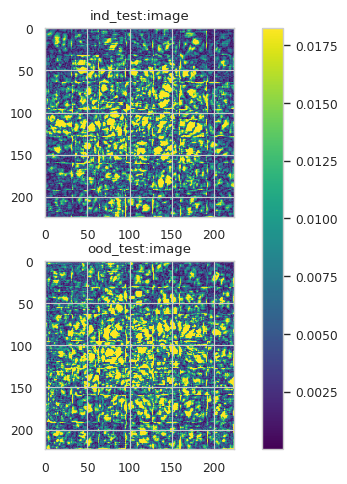

In [51]:
train_activation = torch.mean(train_grads,dim=(0,1,2))
test_activation = torch.mean(test_grads,dim=(0,1,2))
plot_activation(np.abs(train_activation.numpy()), np.abs(test_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/train_test_grad_wrt_input_activation.png', bbox_inches='tight')

In [52]:
layer = "image"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for image


100%|██████████| 1000/1000 [00:36<00:00, 27.57it/s]


register backward hook for image


100%|██████████| 1000/1000 [00:38<00:00, 26.30it/s]


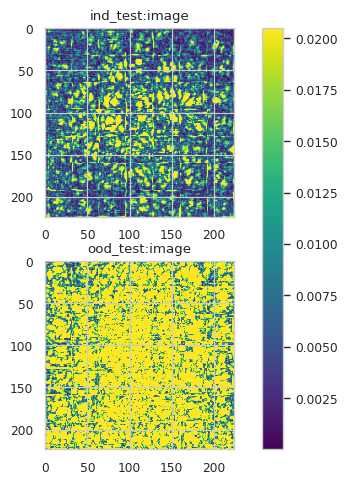

In [54]:
activation = torch.mean(grads,dim=(0,1,2))
ood_activation = torch.mean(ood_grads,dim=(0,1,2))
plot_activation(np.abs(activation.numpy()), np.abs(ood_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

In [43]:
layer = 1
wrt="input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for 1


100%|██████████| 1000/1000 [00:38<00:00, 26.14it/s]


register backward hook for 1


100%|██████████| 1000/1000 [00:36<00:00, 27.19it/s]


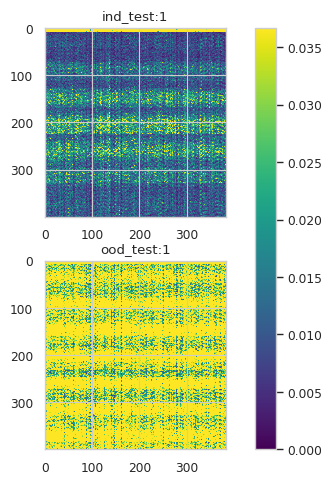

In [44]:
activation = torch.mean(grads,dim=0).reshape(50*8,-1)
ood_activation = torch.mean(ood_grads,dim=0).reshape(50*8,-1)
plot_activation(np.abs(activation.numpy()), np.abs(ood_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

In [45]:
layer = 5
wrt="input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for 5


100%|██████████| 1000/1000 [00:38<00:00, 26.29it/s]


register backward hook for 5


100%|██████████| 1000/1000 [00:36<00:00, 27.08it/s]


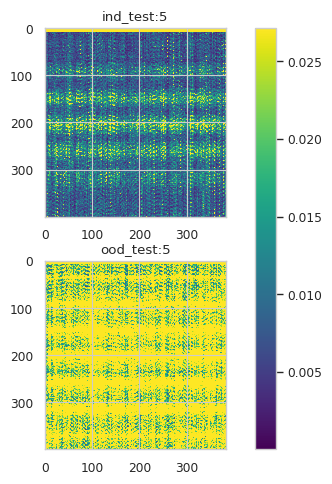

In [46]:
activation = torch.mean(grads,dim=0).reshape(50*8,-1)
ood_activation = torch.mean(ood_grads,dim=0).reshape(50*8,-1)
plot_activation(np.abs(activation.numpy()), np.abs(ood_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_activation.png', bbox_inches='tight')

### GradNorm wrt Weight


In [7]:
def calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer_name,
    loader,
    device,
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm=1,
):


    grads = []

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()

    cnt = 0
    for data, label in tqdm(loader, dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)

        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)

        # #1. 第一种形式loss,log_density
        embedding = net.feature
        log_probs = gaussians_model.log_prob(embedding[:, None, :])
        max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        loss = max_log_probs.sum()

        # # #2. 第二种形式loss,crossEntropy
        # loss = loss_func(out, pred)

        net.zero_grad()
        loss.backward()

        if layer_name=="image":
            layer_grad = net.conv_proj.weight.grad
        elif layer_name in range(12):
            layer_grad = net.encoder.layers[layer_name].mlp[0].weight.grad

        grads.append(layer_grad.cpu().detach())

        cnt += data.shape[0]
        if cnt > 1000:
            break

    return torch.stack(grads)

In [8]:
layer = "image"
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [00:48<00:00, 20.64it/s]


torch.Size([32, 32]) torch.Size([32, 32])


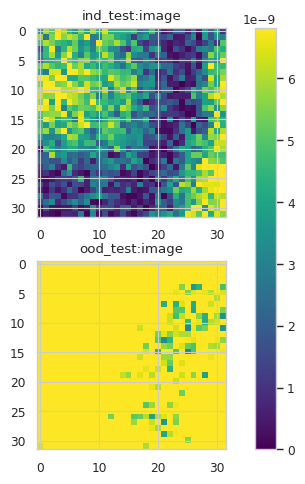

In [9]:
activation = torch.mean(grads,dim=(0,1,2))
ood_activation = torch.mean(ood_grads,dim=(0,1,2))
print(activation.shape,ood_activation.shape)
plot_activation(np.abs(activation.numpy()), np.abs(ood_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')

In [12]:
layer = 1
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [00:51<00:00, 19.35it/s]


torch.Size([3072, 768]) torch.Size([3072, 768])


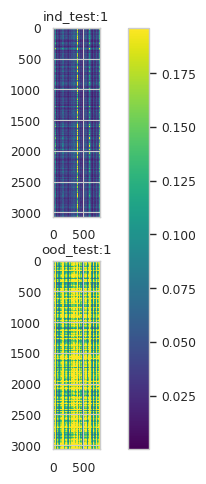

In [15]:
activation = torch.mean(grads,dim=(0,))
ood_activation = torch.mean(ood_grads,dim=(0))
print(activation.shape,ood_activation.shape)
plot_activation(np.abs(activation.numpy()), np.abs(ood_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')

In [16]:
layer = 1
wrt = "weight"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
grads = calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    norm=1,
)
ood_grads = calculate_gradients_activation_wrt_weight(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [00:49<00:00, 20.18it/s]


torch.Size([3072, 768]) torch.Size([3072, 768])


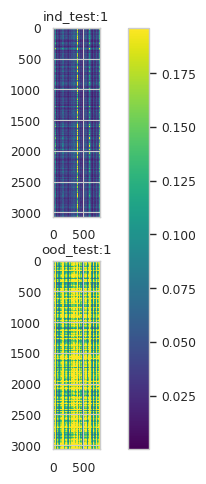

In [17]:
activation = torch.mean(grads,dim=(0,))
ood_activation = torch.mean(ood_grads,dim=(0))
print(activation.shape,ood_activation.shape)
plot_activation(np.abs(activation.numpy()), np.abs(ood_activation.numpy()), f"ind_test:{layer}", f"ood_test:{layer}")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_{wrt}_activation.png', bbox_inches='tight')